In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
import os
import json
import re
import random
import csv
from sklearn.model_selection import StratifiedKFold
# install bitsandbytes and restart

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_dataset(path):
  with open(path, 'r', encoding='utf-8') as f:
    data = json.load(f)
  filtered_data = [
      {'prompt': f'{entry['story']} {entry['question']}', 'belief': 1 if entry['belief'] else 0}
      for entry in data
  ]
  return filtered_data

In [ ]:
tomi = get_dataset("/content/drive/MyDrive/SEF/Data/ToMi/tomi_all.json")
bigtom = get_dataset("/content/drive/MyDrive/SEF/Data/BigToM/bigtom_all.json")

In [ ]:
model_id = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_id, padding=True, truncation=True, model_max_length=512)
tokenizer.padding_side = "right"
tokenizer.truncation_side = "right"

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb_config,
    dtype=torch.float16,
)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

# Extract Last-Token Activation Vectors


In [ ]:
num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads
head_dim = model.config.hidden_size

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def extract_activations(prompts, batch_size=8):
  all_hidden_states = []
  for i in range(0, len(prompts), batch_size):
    batch_prompts = prompts[i:i+batch_size]
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
      outputs = model(**inputs, output_hidden_states=True, attn_implementation="eager")

    hidden_states = outputs.hidden_states[1:]

    attention_mask = inputs["attention_mask"]  # (bs, seq_len)
    lengths = attention_mask.sum(dim=1) - 1     # index of last real token
    batch_last_hidden = []
    for layer_hs in hidden_states:
        # layer_hs: (bs, seq_len, hidden)
        last_tokens = layer_hs[torch.arange(layer_hs.size(0)), lengths]
        batch_last_hidden.append(last_tokens)

    batch_last_hidden = torch.stack(batch_last_hidden, dim=1)
    all_hidden_states.append(batch_last_hidden.cpu())

  global_all_hidden = torch.cat(all_hidden_states, dim=0)

  return global_all_hidden


In [ ]:
tomi_prompts = [entry['prompt'] for entry in tomi]
bigtom_prompts = [entry['prompt'] for entry in bigtom]

last_token_hidden_tomi = extract_activations(tomi_prompts)
last_token_hidden_bigtom = extract_activations(bigtom_prompts)

# Extract Mean-Pooled Activations

In [ ]:
def extract_mean_pooled_hidden(prompts, batch_size=8):
  all_pooled = []
  for i in range(0, len(prompts), batch_size):
    batch = prompts[i:i+batch_size]
    inputs = tokenizer(
        batch,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
      outputs = model(**inputs, output_hidden_states=True)

    hidden_states = outputs.hidden_states[1:]
    attention_mask = inputs["attention_mask"] # [bs, seq_len]
    mask = attention_mask.unsqueeze(-1)
    lengths = attention_mask.sum(dim=1).unsqueeze(-1)

    pooled_layers = []
    for hs in hidden_states:
        # hs: [bs, seq_len, hidden_dim]
        masked_sum = (hs * mask).sum(dim=1)     # [bs, hidden_dim]
        mean_pooled = masked_sum / lengths      # [bs, hidden_dim]
        pooled_layers.append(mean_pooled)

    # Stack layers: [bs, num_layers, hidden_dim]
    batch_pooled = torch.stack(pooled_layers, dim=1)
    all_pooled.append(batch_pooled.cpu())

  return torch.cat(all_pooled, dim=0)

In [ ]:
mean_pooled_tomi = extract_mean_pooled_hidden(tomi_prompts)
mean_pooled_bigtom = extract_mean_pooled_hidden(bigtom_prompts)

# Train Linear Probes

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
def train_layerwise_probes(
    last_token_hidden,
    labels,
    test_size = 0.2,
    random_state=42,
    max_iter=1000
):
  X = last_token_hidden.cpu().numpy()
  y = np.asarray(labels).astype(int)
  N, num_layers, d = X.shape
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=test_size, stratify=y, random_state=random_state
  )
  results = {
      'accuracy': [],
      'auc': [],
      'weights': [],
      'biases': [],
  }

  for layer in range(num_layers):
    # extract activations for this layer
    X_train_l = X_train[:, layer, :]
    X_test_l = X_test[:, layer, :]
    probe = LogisticRegression(
        penalty="l2",
        C = 1.0,
        solver = "lbfgs",
        max_iter=max_iter
    )
    probe.fit(X_train_l, y_train)

    y_pred = probe.predict(X_test_l)
    y_prob = probe.predict_proba(X_test_l)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results['accuracy'].append(acc)
    results['auc'].append(auc)
    results['weights'].append(probe.coef_[0])
    results['biases'].append(probe.intercept_[0])

  return results


In [ ]:
def crossval_layerwise_probes(
    activations, labels, n_splits=5, random_state=42, max_iter=1000
):
    X = activations.cpu().numpy()
    y = np.asarray(labels).astype(int)
    N, num_layers, d = X.shape
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    accs = np.zeros((n_splits, num_layers))
    aucs = np.zeros((n_splits, num_layers))
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        for layer in range(num_layers):
            X_train_l = X_train[:, layer, :]
            X_test_l = X_test[:, layer, :]
            probe = LogisticRegression(
                penalty="l2", C=1.0, solver="lbfgs", max_iter=max_iter
            )
            probe.fit(X_train_l, y_train)
            y_pred = probe.predict(X_test_l)
            y_prob = probe.predict_proba(X_test_l)[:, 1]
            accs[fold, layer] = accuracy_score(y_test, y_pred)
            aucs[fold, layer] = roc_auc_score(y_test, y_prob)
    return accs, aucs

In [ ]:
tomi_labels = [entry['belief'] for entry in tomi]
bigtom_labels = [entry['belief'] for entry in bigtom]

In [ ]:
tomi_accs, tomi_aucs = crossval_layerwise_probes(mean_pooled_tomi, tomi_labels)
bigtom_accs, bigtom_aucs = crossval_layerwise_probes(mean_pooled_bigtom, bigtom_labels)

In [ ]:
print("ToMi 5-fold CV mean accuracy per layer:", tomi_accs.mean(axis=0))
print("BigToM 5-fold CV mean accuracy per layer:", bigtom_accs.mean(axis=0))
print("ToMi 5-fold CV mean AUC per layer:", tomi_aucs.mean(axis=0))
print("BigToM 5-fold CV mean AUC per layer:", bigtom_aucs.mean(axis=0))
print("ToMi overall mean accuracy:", tomi_accs.mean())
print("BigToM overall mean accuracy:", bigtom_accs.mean())

0.56484375 0.4828125


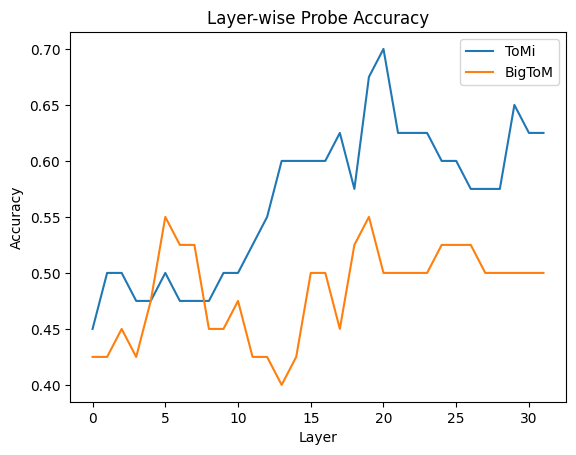

In [ ]:
final_tomi_results = train_layerwise_probes(mean_pooled_tomi, tomi_labels, test_size=0.0)
final_bigtom_results = train_layerwise_probes(mean_pooled_bigtom, bigtom_labels, test_size=0.0)

In [ ]:
best_tomi_layer = np.argmax(final_tomi_results['accuracy'])
best_bigtom_layer = np.argmax(final_bigtom_results['accuracy'])

print("Best ToMi layer:", best_tomi_layer, "Accuracy:", final_tomi_results['accuracy'][best_tomi_layer])
print("Best BigToM layer:", best_bigtom_layer, "Accuracy:", final_bigtom_results['accuracy'][best_bigtom_layer])

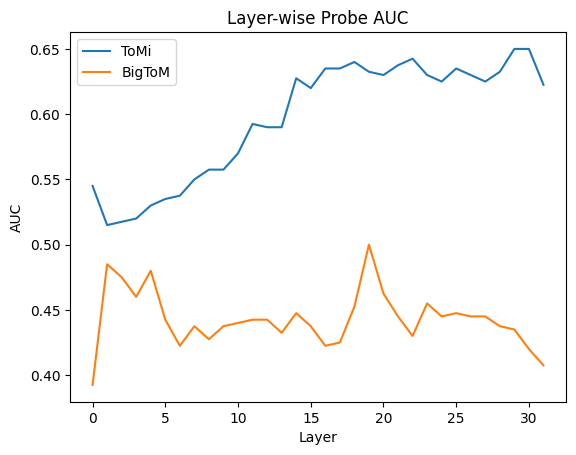

In [ ]:
import matplotlib.pyplot as plt

plt.plot(tomi_results["auc"], label="ToMi")
plt.plot(bigtom_results["auc"], label="BigToM")
plt.xlabel("Layer")
plt.ylabel("AUC")
plt.legend()
plt.title("Layer-wise Probe AUC")
plt.show()

In [ ]:
shuffled_labels = np.random.permutation([entry['belief'] for entry in tomi])
shuffled_results = train_layerwise_probes(
    last_token_hidden_tomi,
    shuffled_labels
)
print(np.mean(shuffled_results['accuracy']), np.mean(shuffled_results['auc']))

0.51796875 0.510859375


In [ ]:
# Save direction vectors (weights) for best layer
tomi_direction = final_tomi_results['weights'][best_tomi_layer]
bigtom_direction = final_bigtom_results['weights'][best_bigtom_layer]

np.save('/content/drive/MyDrive/SEF/Data/NumPy/phase_1_tomi_direction', tomi_direction)
np.save('/content/drive/MyDrive/SEF/Data/NumPy/phase_1_bigtom_direction', bigtom_direction)